In [1]:
# My code
import fast_gillespie as fg
import fast_gillespie_viz as fgv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx

mean_num_monomers =  100.0
interactions_param =  50.0


Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

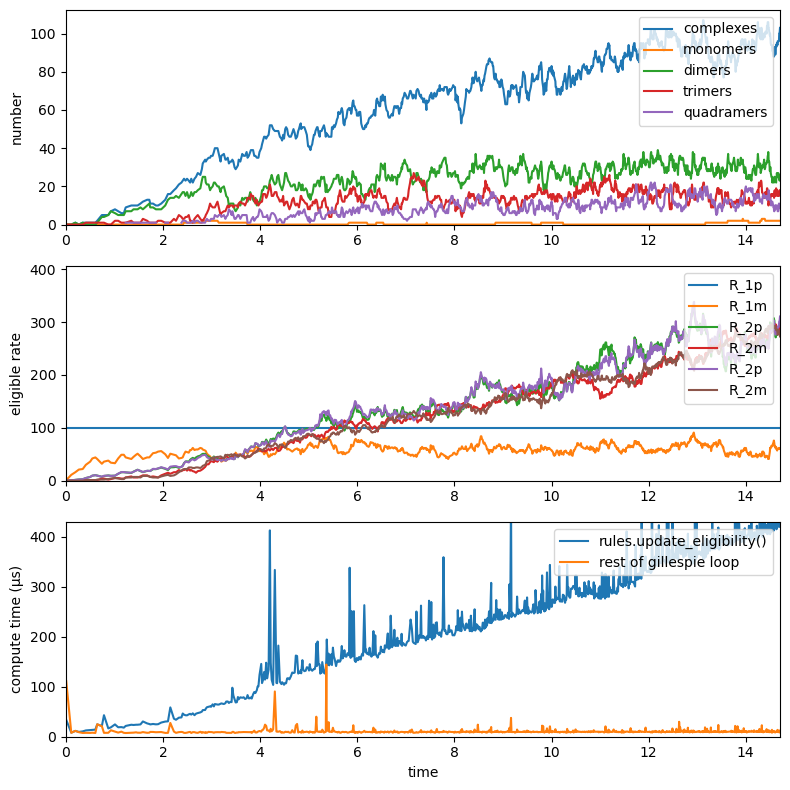

In [2]:
#Define branched homopolymer

# Rates in terms of interpretable quantities
mean_num_monomers = 100.0
interactions_param = 50.0  # I don't have a good interpretation for this
rate2_multiplier = 1
rate1p = mean_num_monomers
rate1m = 1.0
rate2p = rate2_multiplier*interactions_param/(mean_num_monomers**2)
rate2m = rate2_multiplier*1.0

# Print out rate-determining quantities
print('mean_num_monomers = ', mean_num_monomers)
print('interactions_param = ', interactions_param)

# Create fields
A = fg.Field(name='A', index_dim=1)
a = fg.Field(name='a', index_dim=1)
b = fg.Field(name='b', index_dim=1)
c = fg.Field(name='c', index_dim=1)
J = fg.Field(name='J', index_dim=2)

# Create/annihilate A monomer
R_1p = fg.MonomerCreationRule(name='R_1p', rate=rate1p, particle=A, sites=[a,b,c])
R_1m = fg.MonomerAnnihilationRule(name='R_1m', rate=rate1m, particle=A, sites=[a,b,c])

# Create/annihilate J_A:a_B:c interaction
R_2p1 = fg.HeterotypicInteractionCreationRule(name='R_2p', rate=rate2p, A=A, B=A, a=a, b=c, J=J)
R_2m1 = fg.HeterotypicInteractionAnnihilationRule(name='R_2m', rate=rate2m, A=A, B=A, a=a, b=c, J=J)       

# Create/annihilate J_A:b_B:c interaction
R_2p2 = fg.HeterotypicInteractionCreationRule(name='R_2p', rate=rate2p, A=A, B=A, a=b, b=c, J=J)
R_2m2 = fg.HeterotypicInteractionAnnihilationRule(name='R_2m', rate=rate2m, A=A, B=A, a=b, b=c, J=J)    

# Define fock space and rules
space = fg.FockSpace(fields=[A, a, b, c, J])
rules = fg.RuleSet(rules=[R_1p, R_1m, R_2p1, R_2m1, R_2p2, R_2m2])

# Define summary stats to record
def summary_stats_func():
    # Create graph
    G = nx.DiGraph()
    G.add_edges_from(J.indices)
    connected_components = list(nx.weakly_connected_components(G))
    component_sizes = [len(c) for c in nx.weakly_connected_components(G)]
    num_components = len(connected_components)
    size_dict = {size: component_sizes.count(size) for size in set(component_sizes)}
    
    stats_dict = dict(
        complexes=num_components,
        monomers=size_dict.get(1,0),
        dimers=size_dict.get(2,0),
        trimers=size_dict.get(3,0),
        quadramers=size_dict.get(4.0)
    )
    return stats_dict

# Define, initialize, and run simulation
sim = fg.Simulation(space=space, rules=rules, custom_stats_func=summary_stats_func)
sim.initialize_state()
sim.run(num_steps=10_000, record_every=10)

fgv.show_sim_stats(sim, x_is_time=True)


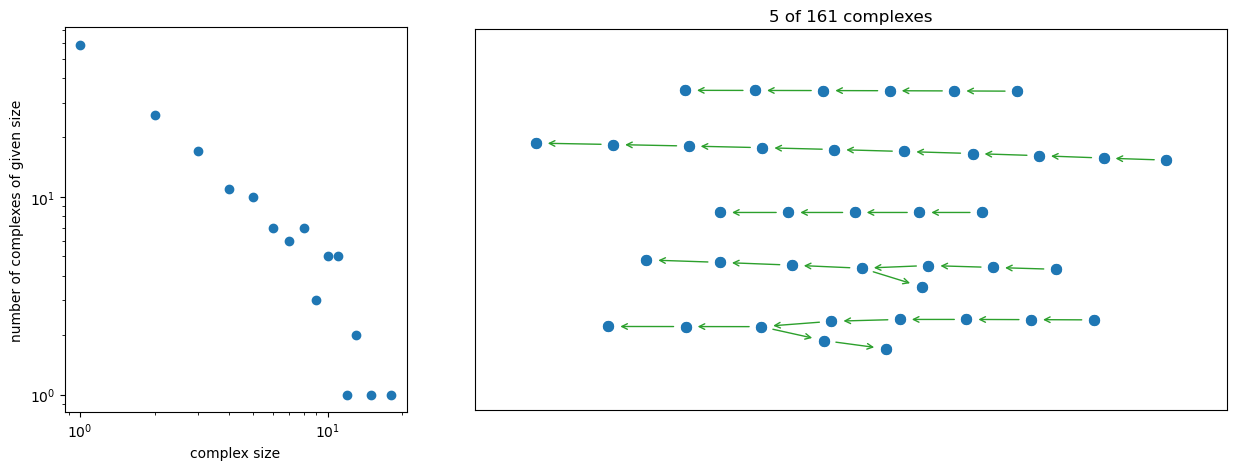

In [3]:
# Compute nodes and edges
nodes=[(f'A_{i[0]}',{'class':'A'}) for i in A.indices]
edges=[(f'A_{i}', f'A_{j}', {'class':'J'}) for i,j in J.indices]

# Specify properties for visualize_complexes
node_properties={
    'A': {'node_color': 'C0', 'node_shape': 'o', 'node_size':50}
}
edge_properties= {
    'J': {'edge_color': 'C2', 'width': 1, 'arrowstyle': '->', 'arrowsize': 10}
}

# Make figure
fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1, 3, figure=fig)

# Plot complex sizes
ax = fig.add_subplot(gs[0, 0])
fgv.show_complex_sizes(nodes, edges, ax=ax)

# Illustrate complexes
ax = fig.add_subplot(gs[0, 1:])
fgv.visualize_complexes(
    nodes=nodes,
    edges=edges,
    node_properties=node_properties,
    edge_properties=edge_properties,
    min_component_length=5,
    max_component_length=10,
    grid_shape=(5,1),
    x_spacing=8,
    y_spacing=1,
    ax=ax,
    iterations=1000,
    learning_rate=0.1)